# 📰 Fake News Detection with Neural Networks
This project classifies news articles as fake or real using a neural network trained on labeled text data.

## 📘 Step 1: Train the Neural Network

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 133s 579ms/step - accuracy: 0.8857 - loss: 0.3085 - val_accuracy: 0.9738 - val_loss: 0.0808
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 141s 629ms/step - accuracy: 0.9840 - loss: 0.0615 - val_accuracy: 0.9903 - val_loss: 0.0329
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 134s 590ms/step - accuracy: 0.9921 - loss: 0.0301 - val_accuracy: 0.9827 - val_loss: 0.0514
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 150s 627ms/step - accuracy: 0.9961 - loss: 0.0171 - val_accuracy: 0.9886 - val_loss: 0.0429
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step - accuracy: 0.9848 - loss: 0.0549

Test Accuracy: 0.9873
281/281 ━━━━━━━━━━━━━━━━━━━━ 13s 46ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      4619
           1       0.99      0.98      0.99      4361

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99   

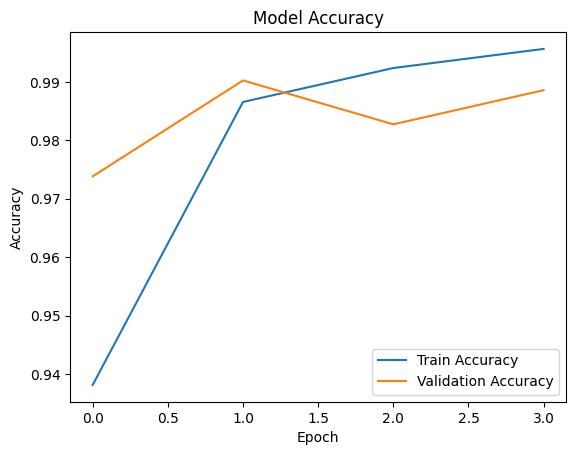

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

# 1. Load the Cleaned Dataset
df = pd.read_csv("fake_news_dataset_final_clean.csv")
df = df[["text", "label"]].dropna()
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 2. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(df["text"], df["label"], test_size=0.2, random_state=42)

# 3. Tokenisation and Padding
MAX_WORDS = 10000
MAX_LEN = 300

tokenizer = Tokenizer(num_words=MAX_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

# 4. Build the Model
model = Sequential()
model.add(Input(shape=(MAX_LEN,)))
model.add(Embedding(input_dim=MAX_WORDS, output_dim=64))
model.add(LSTM(64))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# 5. Train the Model
es = EarlyStopping(monitor='val_loss', patience=2)
history = model.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_split=0.2, callbacks=[es])

# 6. Evaluate the Model
loss, acc = model.evaluate(X_test_pad, y_test)
print(f"\nTest Accuracy: {acc:.4f}")

y_pred = (model.predict(X_test_pad) > 0.5).astype("int32")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, zero_division=0))
print("Confusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))

# 7. Save Model & Tokeniser
model.save("fake_news_model.keras")
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# 8. Plot Accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()
